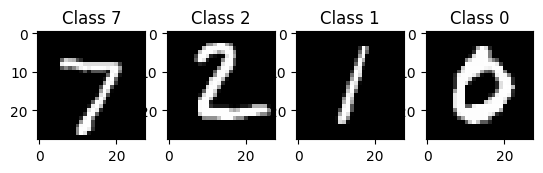

In [2]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Add a channels dimension to the image sets as Akida expects 4-D inputs (corresponding to
# (num_samples, width, height, channels). Note: MNIST is a grayscale dataset and is unusual
# in this respect - most image data already includes a channel dimension, and this step will
# not be necessary.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Display a few images from the test set
f, axarr = plt.subplots(1, 4)
for i in range(0, 4):
    axarr[i].imshow(x_test[i].reshape((28, 28)), cmap=cm.Greys_r)
    axarr[i].set_title('Class %d' % y_test[i])
plt.show()

In [3]:
import keras

#creating the multlayer CNN, which will then be converted to a SNN.
model_keras = keras.models.Sequential([
    keras.layers.Rescaling(1. / 255, input_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    # Separable layer
    keras.layers.DepthwiseConv2D(kernel_size=3, padding='same', strides=2),
    keras.layers.Conv2D(filters=64, kernel_size=1, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
], 'mnistnet')

model_keras.summary()

Model: "mnistnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 13, 13, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 7, 7, 32)         320       
 Conv2D)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          211

In [4]:
from keras.optimizers import Adam
#optimizes the algorithm to attain convergence. changing the learning rate
model_keras.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy'])

_ = model_keras.fit(x_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 8s 4ms/step - loss: 0.1778 - accuracy: 0.9466 - val_loss: 0.0845 - val_accuracy: 0.9752
Epoch 2/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0713 - accuracy: 0.9779 - val_loss: 0.0698 - val_accuracy: 0.9795
Epoch 3/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0528 - accuracy: 0.9829 - val_loss: 0.0642 - val_accuracy: 0.9812
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0426 - accuracy: 0.9862 - val_loss: 0.0529 - val_accuracy: 0.9847
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0347 - accuracy: 0.9883 - val_loss: 0.0558 - val_accuracy: 0.9858
Epoch 6/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0300 - accuracy: 0.9898 - val_loss: 0.0665 - val_accuracy: 0.9805
Epoch 7/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0256 - accuracy: 0.9916 - val_loss: 0.0542 - val_accuracy:

In [5]:
from quantizeml.models import quantize, QuantizationParams


qparams = QuantizationParams(input_weight_bits=4, weight_bits=4, activation_bits=4)
model_quantized = quantize(model_keras, qparams=qparams)
model_quantized.summary()

C:\Users\msaad\AppData\Roaming\Python\Python38\site-packages\quantizeml\models\quantize.py:449: UserWarning: Quantizing per-axis with random calibration samples is not accurate.                       Set QuantizationParams.per_tensor_activations=True when calibrating with                        random samples.
  warnings.warn("Quantizing per-axis with random calibration samples is not accurate.\


1024/1024 [==============================] - 1s 689us/step
Model: "mnistnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_input (InputLayer  [(None, 28, 28, 1)]      0         
 )                                                               
                                                                 
 rescaling (QuantizedRescali  (None, 28, 28, 1)        0         
 ng)                                                             
                                                                 
 conv2d (QuantizedConv2D)    (None, 13, 13, 32)        320       
                                                                 
 re_lu (QuantizedReLU)       (None, 13, 13, 32)        64        
                                                                 
 depthwise_conv2d (Quantized  (None, 7, 7, 32)         384       
 DepthwiseConv2D)                                                

In [ ]:
from quantizeml.models import quantize, QuantizationParams


qparams = QuantizationParams(input_weight_bits=8, weight_bits=8, activation_bits=8)
model_quantized = quantize(model_keras, qparams=qparams)
model_quantized.summary()

In [ ]:
from quantizeml.models import quantize, QuantizationParams


qparams = QuantizationParams(input_weight_bits=2, weight_bits=2, activation_bits=2)
model_quantized = quantize(model_keras, qparams=qparams)
model_quantized.summary()

In [6]:
def compile_evaluate(model):
    """ Compiles and evaluates the model, then return accuracy score. """
    model.compile(metrics=['accuracy'])
    return model.evaluate(x_test, y_test, verbose=0)[1]


print('Test accuracy after 8-bit quantization:', compile_evaluate(model_quantized))

Test accuracy after 8-bit quantization: 0.9732000231742859


In [7]:
model_quantized = quantize(model_keras, qparams=qparams,
                           samples=x_train, num_samples=1024, batch_size=100, epochs=2)
#this is calibration

print('Test accuracy after calibration:', compile_evaluate(model_quantized))

11/11 [==============================] - 0s 4ms/step
Test accuracy after calibration: 0.9782000184059143


In [11]:
from cnn2snn import convert

model_akida = convert(model_quantized)
model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[28, 28, 1]  [1, 1, 10]    1          5     
______________________________________________

__________________________________________________________________
Layer (type)                        Output shape  Kernel shape  

=============== SW/conv2d-dequantizer_1 (Software) ===============

conv2d (InputConv2D)                [13, 13, 32]  (3, 3, 1, 32) 
__________________________________________________________________
depthwise_conv2d (DepthwiseConv2D)  [7, 7, 32]    (3, 3, 32, 1) 
__________________________________________________________________
conv2d_1 (Conv2D)                   [7, 7, 64]    (1, 1, 32, 64)
__________________________________________________________________
dense (Dense2D)                     [1, 1, 10]    (3136, 10)    
__________________________________________________________________
dequantizer_1 (Dequantizer)         [1,

In [17]:
import time
class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        self.end_time = time.perf_counter()
        return self.end_time - self.start_time

Prediction took 0.0004 seconds
Input Label: 7


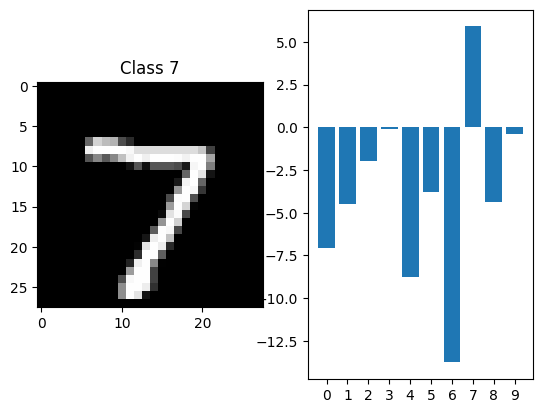

[ -7.0917134   -4.5075      -1.9511931   -0.08526181  -8.772125
  -3.7957418  -13.7638855    5.897206    -4.3806286   -0.36917958]


In [18]:

# Test a single example
sample_image = 0
image = x_test[sample_image]
timer = Timer()
timer.start()
outputs = model_akida.predict(image.reshape(1, 28, 28, 1))
prediction_time = timer.stop()

print(f"Prediction took {prediction_time:.4f} seconds")
print('Input Label: %i' % y_test[sample_image])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(x_test[sample_image].reshape((28, 28)), cmap=cm.Greys_r)
axarr[0].set_title('Class %d' % y_test[sample_image])
axarr[1].bar(range(10), outputs.squeeze())
axarr[1].set_xticks(range(10))
plt.show()

print(outputs.squeeze())